In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart.csv


In [39]:
!pip install --upgrade pip
!pip install tabpfn

In [40]:
df = pd.read_csv("../input/heart.csv")

In [41]:
# from sklearn.preprocessing import OrdinalEncoder

# oe=OrdinalEncoder()
# X = df.drop('HeartDisease', axis=1)
# y = df['HeartDisease']

# X = oe.fit_transform(X)

In [47]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

df['Sex']=le.fit_transform(df['Sex'])
df['RestingECG']=le.fit_transform(df['RestingECG'])
df['ChestPainType']=le.fit_transform(df['ChestPainType'])
df['ExerciseAngina']=le.fit_transform(df['ExerciseAngina'])
df['ST_Slope']=le.fit_transform(df['ST_Slope'])

X = df.drop('HeartDisease', axis=1).to_numpy()
y = df['HeartDisease'].to_numpy()

In [48]:
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# scaler.fit(X)

# X_scaled= scaler.transform(X)

In [49]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score ,accuracy_score
def show_confusion(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate precision and recall
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return conf_matrix, precision, recall, accuracy

In [50]:
def plot_cv_error_bars(conf_matrices, precisions, recalls, accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Confusion Matrix Plot
    all_elements = [cm.flatten() for cm in conf_matrices]
    mean = np.mean(all_elements, axis=0)
    std = np.std(all_elements, axis=0) 
    labels = ['TN', 'FP', 'FN', 'TP'] 
    axes[0].bar(labels, mean, yerr=std, capsize=5) 
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xticks(range(len(labels)))  

    # Other Metrics Plot
    metrics = ['Precision', 'Recall', 'Accuracy']
    scores = [precisions, recalls, accuracies]
    colors = ['b', 'g', 'r']  # Optional for color distinction

    for i, (metric, score) in enumerate(zip(metrics, scores)):
        mean = np.mean(score)
        std = np.std(score)
        axes[1].bar(i, mean, yerr=std, capsize=5, color=colors[i])  

    axes[1].set_title('Other Metrics')
    axes[1].set_xticks(range(len(metrics))) 
    axes[1].set_xticklabels(metrics)

    plt.tight_layout()
    plt.show()


In [53]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier


kf = KFold(n_splits=4)
conf_matrix, precision, recall, accuracy = [], [], [], []
for i, (train_split_idx, test_split_idx) in enumerate(kf.split(X, y)):
    X_train, y_train = X[train_split_idx], y[train_split_idx]
    X_test, y_test = X[test_split_idx], y[test_split_idx]
    classifier = TabPFNClassifier(device='cuda', N_ensemble_configurations=32)
    classifier.fit(X_train, y_train)
    y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)
    out = show_confusion(y_eval, y_test)
    conf_matrix.append(out[0])
    precision.append(out[1])
    recall.append(out[2])
    accuracy.append(out[3])

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


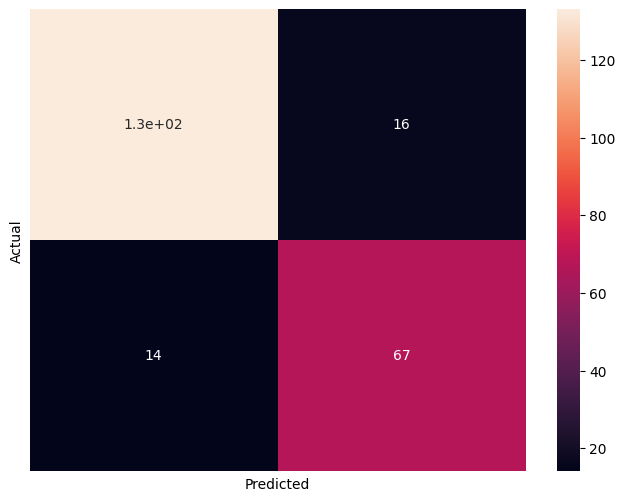

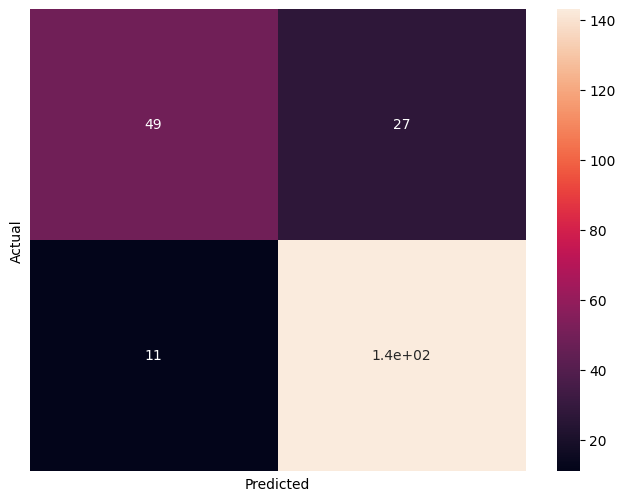

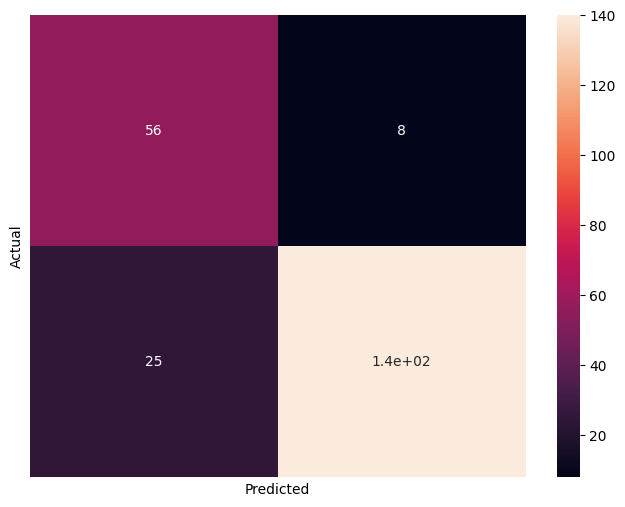

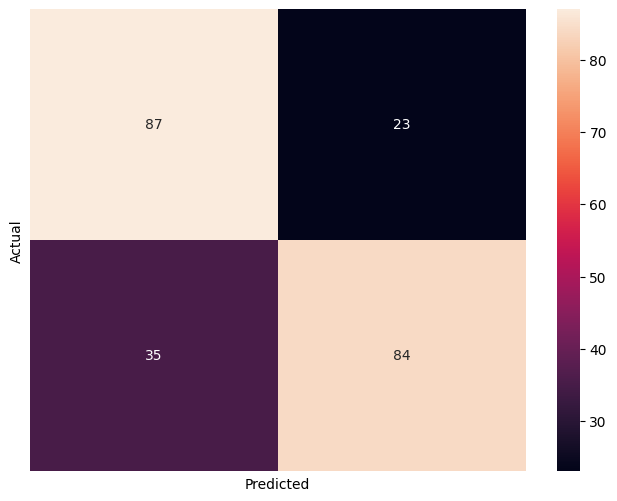

In [54]:
import seaborn as sns 
import matplotlib.pyplot as plt

for matrix in conf_matrix:
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, xticklabels=False, yticklabels=False) 
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

In [55]:
print("Precision: ", precision)
print("Accuracy: ", accuracy)
print("Recall: ", recall)

Precision:  [0.8072289156626506, 0.8411764705882353, 0.9459459459459459, 0.7850467289719626]
Accuracy:  [0.8695652173913043, 0.8347826086956521, 0.8558951965065502, 0.7467248908296943]
Recall:  [0.8271604938271605, 0.9285714285714286, 0.8484848484848485, 0.7058823529411765]


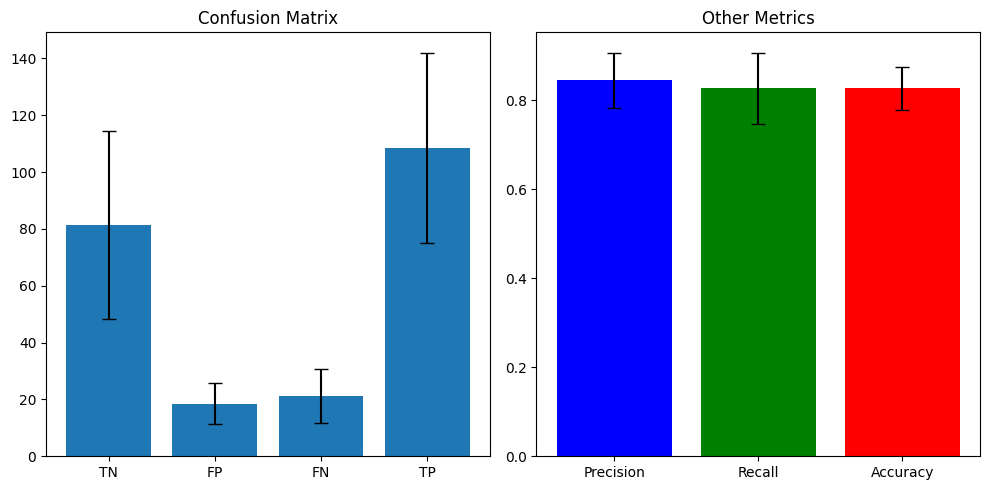

In [56]:
plot_cv_error_bars(conf_matrix, precision, recall, accuracy)